# import library

In [37]:
import numpy as np
from scipy.io import loadmat
from scipy.fftpack import fft
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import math

# split data

In [38]:
Data = loadmat('file.mat')
chan = Data['Channels']
time = Data['Time'][0]
data = Data['Data']
o1 = data[0, :]
o2 = data[1, :]
oz = data[2, :]

#  show data with plot

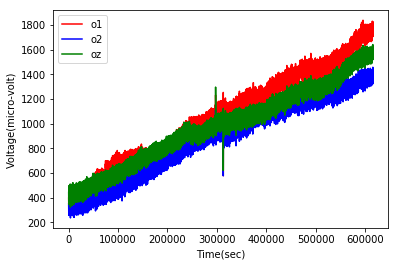

In [39]:
plt.plot(time, o1, 'r')
plt.plot(time, o2, 'b')
plt.plot(time, oz, 'g')
plt.legend(('o1', 'o2', 'oz'))
plt.xlabel('Time(sec)')
plt.ylabel('Voltage(micro-volt)')
plt.show()

# make one signal

In [40]:
AvgOcp = (o1 + o2 + oz) / 3
AvgOcp = AvgOcp - np.mean(AvgOcp)

# smooth function

In [41]:
def smooth(a,WSZ):
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))


# show  with plot 

# MyFT function

In [42]:
def MyFT(Signal, Fs):
    MFT = fft(Signal)
    Freq = np.linspace(-Fs/2, Fs/2, len(Signal))
    MFT = MFT[Freq >= 0]
    Freq = Freq[Freq >= 0]
    MFT = MFT[::-1]
    return Freq, (abs(MFT)**2)/ len(Signal)

In [43]:
Fs = 1000
SignalSize = len(AvgOcp)
WindowSize = 1024
JumpSize = WindowSize//4
AvgOcp = (o1 + o2 + oz) / 3

In [44]:
FreqVec = np.linspace(-Fs/2, Fs/2, WindowSize)
nFreqPoints = sum(FreqVec>=0)
nTimePoints = math.ceil((SignalSize-WindowSize)/JumpSize)
TimeVec = (WindowSize/2 + (np.arange(nTimePoints)*JumpSize))/Fs
Power = np.zeros((nFreqPoints, nTimePoints))
StartIdx = 0

for t in range(nTimePoints):
    Window = AvgOcp[StartIdx: WindowSize+StartIdx]
    FreqVec, i_power = MyFT(Window, 1000)
    Power[:, t] = i_power
    StartIdx += JumpSize

In [45]:
ThetaPower = np.mean(Power[(FreqVec>4) & (FreqVec<8)],0)
GammaPower = np.mean(Power[(FreqVec>32) & (FreqVec<100)],0)

ThetaPowerdB = 10 * np.log10(ThetaPower)
GammaPowerdB = 10 * np.log10(GammaPower)

ThetaPowerdBSmoothed = smooth(ThetaPowerdB, 151)
GammaPowerdBSmoothed = smooth(GammaPowerdB, 151)

# Show Theta

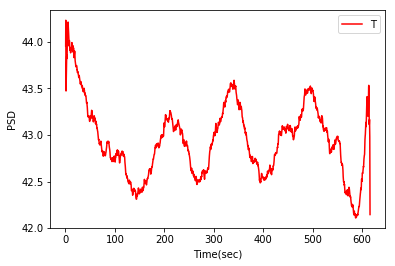

In [46]:
plt.plot(TimeVec,ThetaPowerdBSmoothed,'r')
plt.legend(('Theta'))
plt.xlabel('Time(sec)')
plt.ylabel('PSD')
plt.show()

# Show Gamma

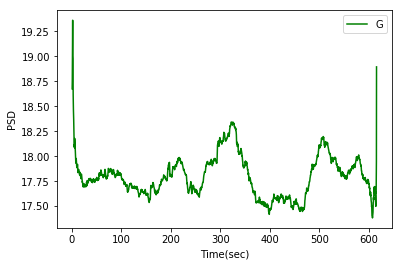

In [47]:
plt.plot(TimeVec,GammaPowerdBSmoothed,'g')
plt.legend(('Gamma'))
plt.xlabel('Time(sec)')
plt.ylabel('PSD')
plt.show()